## A Comparision Of The Performance of Logistic Regression, Support Vector Machines, And Transfer Learning Trained VGG16 On The Detection Of COVID-19 In Chest X-rays

## IMPORTS

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers import AveragePooling2D,Dropout,GlobalAveragePooling2D
from keras.regularizers import l2,l1
from tensorflow.keras.optimizers import Adam
from os import listdir
import os
import cv2
import shutil
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## KAGGLE PIPELINE

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sumiranthakur","key":"ece9e879a334e861ad133bc4d50f797a"}'}

In [3]:
!pip install -q kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat '/content/.kaggle/kaggle.json': No such file or directory
- path is now set to: {/content}


In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content --force

 99% 1.14G/1.15G [00:08<00:00, 88.1MB/s]
100% 1.15G/1.15G [00:08<00:00, 143MB/s] 


In [0]:
%%capture
!unzip \*.zip

## CREATING INITIAL TRAINING DIRECTORIES

In [6]:
# listing all image classes in train and test
list_classes = listdir('/content/COVID-19 Radiography Database')
list_classes

['Viral Pneumonia',
 'README.md.txt',
 'NORMAL.metadata.xlsx',
 'COVID-19',
 'COVID-19.metadata.xlsx',
 'Viral Pneumonia.matadata.xlsx',
 'NORMAL']

In [0]:
# declaring these now, so it will be easier to copy over the data
normal= '/content/COVID-19 Radiography Database/NORMAL'
covid_19= '/content/COVID-19 Radiography Database/COVID-19'
viral_pneumonia= '/content/COVID-19 Radiography Database/Viral Pneumonia'

In [8]:

#we define some helper functions to help copy, move the data

def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def move_files(random_files, input_dir, output_dir):
  for file in random_files:
        shutil.move(os.path.join(input_dir, file), output_dir)

def copy_over(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

def move_over(input_dir, output_dir, N):
  file_list = get_file_list(input_dir)
  random_files = get_random_files(file_list, N)
  move_files(random_files, input_dir, output_dir)

#creating our new directories
def append_to_path(path):
  try:
      os.makedirs(path)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s" % path)


path_train_covid= '/content/training_data/COVID-19'
path_train_normal= '/content/training_data/NORMAL'
path_train_viral_pnuemonia= '/content/training_data/VIRAL PNEUMONIA'


append_to_path(path_train_covid)
append_to_path(path_train_normal)
append_to_path(path_train_viral_pnuemonia)

length= min([len(listdir(normal)),len(listdir(covid_19)),len(listdir(viral_pneumonia))])
#since the covid 19 directory has 219 images we will try to make sure that we randomly select 219 images
#from the viral pneumonia and normal categories. We will pick the smallest of these three values always

copy_over(covid_19,path_train_covid,length)
copy_over(normal,path_train_normal,length)
copy_over(viral_pneumonia,path_train_viral_pnuemonia,length)

#check if it worked

print(len(listdir(path_train_covid))==len(listdir(covid_19)))


Successfully created the directory /content/training_data/COVID-19
Successfully created the directory /content/training_data/NORMAL
Successfully created the directory /content/training_data/VIRAL PNEUMONIA
True


## MAKING DATA FOR LOGISTIC REGRESSION AND SVM

In [0]:
## we have to make our training and test splits for logistic reg and svm here, since we use scikit learn
## I have to do this before I make the test directories for the CNN model
def make_data(dir):
  data=[]
  for image in (os.listdir(dir)):
    path= os.path.join(dir,image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img_resized = cv2.resize(img, (224,224))
    data.append(np.asarray(img_resized).flatten())
  return data

def make_labels(label,len):
 return np.array([label for i in range(len)])

training_data_covid= make_data(path_train_covid)
training_data_normal= make_data(path_train_normal)
training_data_viral_pneumonia= make_data(path_train_viral_pnuemonia)
training_data= np.concatenate((training_data_covid,training_data_normal,training_data_viral_pneumonia),axis=0)
data_fixed = (training_data-np.min(training_data))/(np.max(training_data)-np.min(training_data))
covid_labels= make_labels('COVID-19',219)
normal_labels= make_labels('NORMAL',219)
viral_pneumonia_labels= make_labels('VIRAL PNEUMONIA',219)
labels= np.concatenate((covid_labels,normal_labels,viral_pneumonia_labels),axis=0)
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(data_fixed, labels, test_size=0.15, random_state=50)
X_train, X_val, Y_train, Y_val= train_test_split(X_train_temp,Y_train_temp,test_size=0.15,random_state=50)

## TESTING DIRECTORY FOR VGG16 MODEL

In [10]:
# time to make our test set for our CNN, first we make the directories again
path_test_covid= '/content/test_data/COVID-19'
path_test_normal= '/content/test_data/NORMAL'
path_test_viral_pnuemonia= '/content/test_data/VIRAL PNEUMONIA'

append_to_path(path_test_covid)
append_to_path(path_test_normal)
append_to_path(path_test_viral_pnuemonia)

#copying over ~15% to the test set
#here we ave to make sure that our files get moved not just copied
#so we use the move_over function

move_over(path_train_covid,path_test_covid,int(0.15*length))
move_over(path_train_normal,path_test_normal,int(0.15*length))
move_over(path_train_viral_pnuemonia,path_test_viral_pnuemonia,int(0.15*length))

#check if it worked
print(len(listdir(path_train_covid)))
print(len(listdir(path_test_covid)))
print(len(listdir(path_train_normal)))
print(len(listdir(path_test_normal)))
print(len(listdir(path_train_viral_pnuemonia)))
print(len(listdir(path_test_viral_pnuemonia)))

Successfully created the directory /content/test_data/COVID-19
Successfully created the directory /content/test_data/NORMAL
Successfully created the directory /content/test_data/VIRAL PNEUMONIA
187
32
187
32
187
32


## HELPER FUNCTIONS FOR ANALYSIS

In [11]:
def avg_pixel(paths):
  len_total=0
  dim1=0
  dim2=0
  for path in paths:
    img_list= listdir(path)
    len_total+= len(img_list)
    for each_image in img_list:
      if each_image.endswith(".png"):
        full_path = path + '/' + each_image
        image = cv2.imread(full_path)
        dim1+=image.shape[0]
        dim2+=image.shape[1]
  avg_1= dim1/len_total
  avg_2= dim2/len_total
  return avg_1,avg_2

avg_pixel([path_train_covid,path_train_normal,path_train_viral_pnuemonia,path_test_covid,path_test_normal,path_test_viral_pnuemonia])

(1024.0, 1024.0)

I defined the fucnction above to see if the kaggle dataset truly had standardized image size, and it did!

In [0]:
#### I took this from stackoverflow to plot the confusion matrix
#### Here are the links: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
#### http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


## SIDE NOTE ABOUT CONFUSION MATRICES AND METRICS
 
#What is a confusion matrix?

A confusion matrix is an error matrix, where the layout helps visualize the number of samples correctly and incorrectly classified for a given set of labels within a prediction problem. The columns represent the predicted label, with the rows representing the true label, and the diagonal representing exactly correct classification rates for each given label. 

## What are precision, recall, and f1-score?

Precision is defined as the number of true positives divided by the number of total predicted positive labels (true positives + false positives). Recall is the number of true positives divided by the number of total positive labels in the original test set. The f-1 score is weighted average of the precision and recall, it is also bounded between 0 and 1 just as the metrics before






## LOGISTIC REGRESSION MODEL


In [13]:
grid={"C":np.logspace(-4,4,7), 'penalty': ["l2"]}
log_reg = LogisticRegression(solver='newton-cg')
log_reg_cv = GridSearchCV(log_reg, grid, cv=10)
log_reg_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='newton-cg',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
y_pred = log_reg_cv.predict(X_val)
val_acc=sklearn.metrics.accuracy_score(y_pred,Y_val)
print(f'The validation accuracy is {val_acc}')

The validation accuracy is 0.9166666666666666


The test accuracy is 0.8686868686868687


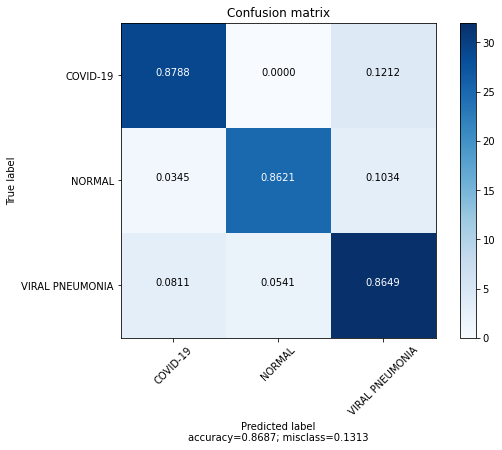

Classification Report
                 precision    recall  f1-score   support

       COVID-19       0.88      0.88      0.88        33
         NORMAL       0.93      0.86      0.89        29
VIRAL PNEUMONIA       0.82      0.86      0.84        37

       accuracy                           0.87        99
      macro avg       0.88      0.87      0.87        99
   weighted avg       0.87      0.87      0.87        99



In [28]:
y_pred = log_reg_cv.predict(X_test)
test_acc=sklearn.metrics.accuracy_score(y_pred,Y_test)
print(f'The test accuracy is {test_acc}')
target_names= ['COVID-19', 'NORMAL', 'VIRAL PNEUMONIA']
cm= confusion_matrix(Y_test,y_pred)
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)
print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=target_names))

## LINEAR KERNEL SVM 




In [19]:
grid={"C":np.logspace(-4,4,7)}
svc=SVC(kernel='linear')
lin_kernel_svm_cv=GridSearchCV(svc,grid,cv=10)
lin_kernel_svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
y_pred = lin_kernel_svm_cv.predict(X_val)
val_acc=sklearn.metrics.accuracy_score(y_pred,Y_val)
print(f'The validation accuracy is {val_acc}')

The validation accuracy is 0.9166666666666666


The test accuracy is 0.898989898989899


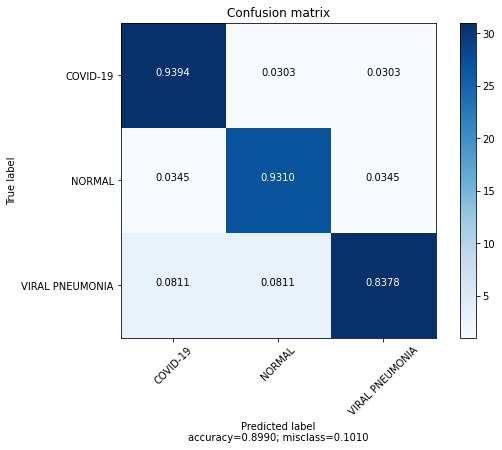

Classification Report
                 precision    recall  f1-score   support

       COVID-19       0.89      0.94      0.91        33
         NORMAL       0.87      0.93      0.90        29
VIRAL PNEUMONIA       0.94      0.84      0.89        37

       accuracy                           0.90        99
      macro avg       0.90      0.90      0.90        99
   weighted avg       0.90      0.90      0.90        99



In [29]:
y_pred = lin_kernel_svm_cv.predict(X_test)
test_acc=sklearn.metrics.accuracy_score(y_pred,Y_test)
print(f'The test accuracy is {test_acc}')
cm= confusion_matrix(Y_test,y_pred)
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)
print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=target_names))

## RBF KERNEL SVM

In [22]:
svc=SVC(kernel='rbf')
rbf_kernel_svm_cv=GridSearchCV(svc,grid,cv=10)
rbf_kernel_svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
y_pred = rbf_kernel_svm_cv.predict(X_val)
val_acc=sklearn.metrics.accuracy_score(y_pred,Y_val)
print(f'The validation accuracy is {val_acc}')

The validation accuracy is 0.9404761904761905


The test accuracy is 0.898989898989899


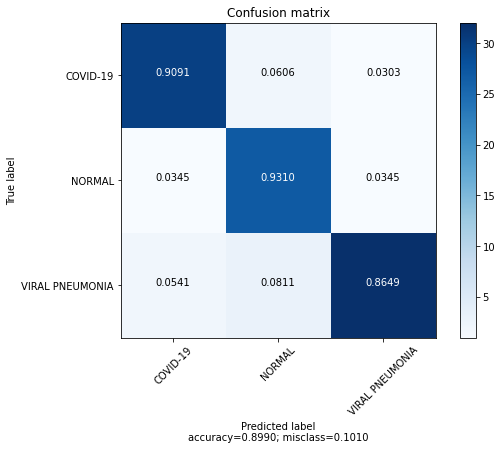

Classification Report
                 precision    recall  f1-score   support

       COVID-19       0.91      0.91      0.91        33
         NORMAL       0.84      0.93      0.89        29
VIRAL PNEUMONIA       0.94      0.86      0.90        37

       accuracy                           0.90        99
      macro avg       0.90      0.90      0.90        99
   weighted avg       0.90      0.90      0.90        99



In [30]:
y_pred = rbf_kernel_svm_cv.predict(X_test)
test_acc=sklearn.metrics.accuracy_score(y_pred,Y_test)
print(f'The test accuracy is {test_acc}')
cm= confusion_matrix(Y_test,y_pred)
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)
print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=target_names))

## VGG 16 MODEL

In [25]:

datagen = ImageDataGenerator(
              rescale=1./255,
              rotation_range=15, 
              fill_mode = 'nearest',
              validation_split = 0.15
            )
# powers of 2 help for batch size, why did we pick such a smaller number, the reason is because our image dataset is only 657 images large
b_size = 8
img_size = (224,224)
num_epochs= 30
l_r= 1e-3
len_test= 96

#creating training_set
train_generator = datagen.flow_from_directory(
directory= '/content/training_data',
target_size=img_size,
batch_size=b_size,
subset = "training",
class_mode="categorical",
shuffle=True,
seed=50
)

#creating validation set
validation_generator = datagen.flow_from_directory(
directory='/content/training_data',
target_size=img_size,
batch_size=b_size,
subset = "validation",
class_mode="categorical",
shuffle=True,
seed=50
)

#number of total batches made 
num_iter_train= int(train_generator.n/train_generator.batch_size)
num_iter_valid=int(validation_generator.n/validation_generator.batch_size)
base_model= VGG16(weights='imagenet',
      include_top=False,
      input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='elu'))
model.add(Dropout(0.4))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer=optimizers.Adam(lr=l_r, decay= l_r/num_epochs),
  metrics=['acc'])
model.summary()
trained_VGG16=model.fit_generator(train_generator,
            steps_per_epoch = num_iter_train,
            validation_data = validation_generator,
            validation_steps = num_iter_valid,
            epochs= num_epochs,
            verbose=2,
            shuffle= False                       
            )

test_datagen= ImageDataGenerator(rescale=1. / 255)


test_generator= test_datagen.flow_from_directory(
        directory= '/content/test_data',
        target_size=img_size,
        batch_size=b_size,
        class_mode="categorical",
        shuffle=False,
        seed=50)

test_generator.reset()
test_size= int(len_test/b_size)

result= model.evaluate_generator(test_generator,
                                steps= test_size,
                                verbose = 1,
                                workers= 1)
vgg16_result= model.predict_generator(test_generator,
                                steps=test_size,
                                verbose = 1,
                                workers=1)
print(f'The test loss is {result[0]}')
print(f'The test accuracy is {result[1]}')


Found 477 images belonging to 3 classes.
Found 84 images belonging to 3 classes.
58892288/58889256 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)  

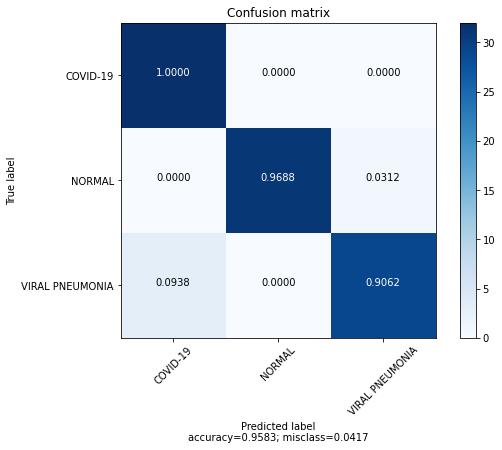

Classification Report
                 precision    recall  f1-score   support

       COVID-19       0.91      1.00      0.96        32
         NORMAL       1.00      0.97      0.98        32
VIRAL PNEUMONIA       0.97      0.91      0.94        32

       accuracy                           0.96        96
      macro avg       0.96      0.96      0.96        96
   weighted avg       0.96      0.96      0.96        96



In [26]:

vgg16_pred= np.argmax(vgg16_result,axis=1)
cm= confusion_matrix(test_generator.classes, vgg16_pred)
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)
print('Classification Report')
print(classification_report(test_generator.classes, vgg16_pred, target_names=target_names))

## WHY VGG16?

We actually observe that the transfer learning VGG16 performs better than the RBF kernel SVM. However, in accuracies regarding medical data, even the tiniest percents can mean a lot. Also, while logistic regression and kernelized SVM did fairly well, they simply don't scale as well with larger datasets. Since we just used one kaggle dataset and scaled it to have an even number of normal, covid-19, and viral pneumonia x rays, we only end up with a total of 657 samples. A future extension to this could including integrating other datasets once data becomes more public. Also, scikit-learn is not GPU enabled, and the training time for a GPU enabled keras model will be faster than that of scikit learn's logistic regression and SVM for much larger datasets.

This was an extremely fun project, and I would like to thank Professor Ranade and the EECS 127 course staff for a wonderful semester.

Keep in mind that this is simply a proof of concept and could be a useful tool down the line, but is by no means an accurate diagnostic tool. 